# Linux Commits Zone Analysis

This notebook analyzes Linux kernel commits from a JSONL file, categorizing changes by root directory zones.

## Import Required Libraries

Import necessary libraries for data processing and visualization.

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load JSONL Data

Read the commit data from the JSONL file.

In [3]:
# Load the JSONL file
commits = []
with open('../data/1000-linux-commits.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        commits.append(json.loads(line))

print(f"Loaded {len(commits)} commits")
print(f"\nSample commit structure:")
print(json.dumps(commits[0], indent=2)[:500] + "...")

Loaded 1000 commits

Sample commit structure:
{
  "backend_name": "Git",
  "backend_version": "0.13.0",
  "category": "commit",
  "classified_fields_filtered": null,
  "data": {
    "Author": "Greg Kroah-Hartman <gregkh@linuxfoundation.org>",
    "AuthorDate": "Thu Jan 6 10:54:01 2022 +0100",
    "Commit": "Heiko Carstens <hca@linux.ibm.com>",
    "CommitDate": "Sat Jan 8 17:44:05 2022 +0100",
    "Signed-off-by": [
      "Greg Kroah-Hartman <gregkh@linuxfoundation.org>",
      "Heiko Carstens <hca@linux.ibm.com>"
    ],
    "commit": "0704...


## Extract Zones from File Paths

Create a function to extract the root directory (zone) from file paths.

In [4]:
def extract_zone(file_path):
    """
    Extract the root directory zone from a file path.
    
    Args:
        file_path (str): The file path to process
        
    Returns:
        str: The zone (first directory after root, or 'root' for files in root directory)
    """
    if '/' in file_path:
        # Extract the first directory after root
        zone = file_path.split('/')[0]
    else:
        # File is in the root directory
        zone = 'root'
    
    return zone

## Add Zone Information to Commits

Process each commit to extract all unique zones affected.

In [5]:
# Add zone information to each commit
for commit in commits:
    # Get the list of modified files
    files = commit.get('data', {}).get('files', [])
    
    # Extract zones from all files
    zones = set()
    for file_info in files:
        file_path = file_info.get('file', '')
        if file_path:
            zone = extract_zone(file_path)
            zones.add(zone)
    
    # Add the zone field (as a list for consistency)
    commit['zone'] = sorted(list(zones))

# Display sample results
print("Sample commits with zone information:")
for i in range(min(3, len(commits))):
    files_list = [f.get('file', '') for f in commits[i]['data']['files']]
    print(f"\nCommit {i+1}:")
    print(f"  Files: {files_list[:3]}{'...' if len(files_list) > 3 else ''}")
    print(f"  Zones: {commits[i]['zone']}")

Sample commits with zone information:

Commit 1:
  Files: ['drivers/s390/block/dasd_devmap.c']
  Zones: ['drivers']

Commit 2:
  Files: ['arch/x86/include/asm/page_64.h', 'arch/x86/include/asm/pgtable.h', 'arch/x86/include/asm/realmode.h']...
  Zones: ['arch']

Commit 3:
  Files: ['arch/x86/mm/init_64.c', 'include/linux/bootmem_info.h', 'mm/bootmem_info.c']...
  Zones: ['arch', 'include', 'mm']


## Count Affected Zones per Commit

Add a field indicating the number of different zones affected in each commit.

In [6]:
# Add the number of zones affected
for commit in commits:
    commit['num_zones'] = len(commit['zone'])

# Create a DataFrame for easier analysis
df = pd.DataFrame([
    {
        'commit_hash': commit['data'].get('commit', 'unknown'),
        'zone': commit['zone'],
        'num_zones': commit['num_zones']
    }
    for commit in commits
])

print(f"Total commits: {len(df)}")
print(f"\nDistribution of number of zones per commit:")
print(df['num_zones'].value_counts().sort_index())
print(f"\nSummary statistics:")
print(df['num_zones'].describe())

Total commits: 1000

Distribution of number of zones per commit:
num_zones
0       1
1     877
2      85
3      17
4      14
5       3
7       1
21      1
23      1
Name: count, dtype: int64

Summary statistics:
count    1000.000000
mean        1.220000
std         1.095811
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        23.000000
Name: num_zones, dtype: float64


## Analyze Commits by Zone

Count how many commits affect each zone.

In [7]:
# Count commits per zone (a commit can affect multiple zones)
zone_counter = Counter()

for commit in commits:
    for zone in commit['zone']:
        zone_counter[zone] += 1

# Create a DataFrame for the zone statistics
zone_df = pd.DataFrame([
    {'zone': zone, 'commit_count': count}
    for zone, count in zone_counter.most_common()
])

print(f"Total unique zones: {len(zone_df)}")
print(f"\nTop 15 zones by number of commits:")
print(zone_df.head(15).to_string(index=False))

Total unique zones: 24

Top 15 zones by number of commits:
         zone  commit_count
      drivers           533
         arch           130
      include           104
Documentation            94
           fs            63
        tools            54
          net            53
        sound            47
       kernel            29
           mm            27
         root            27
          lib             9
        block             8
      scripts             7
     security             7


## Visualize Commits Distribution by Zone

Generate visualizations showing the distribution of commits across zones.

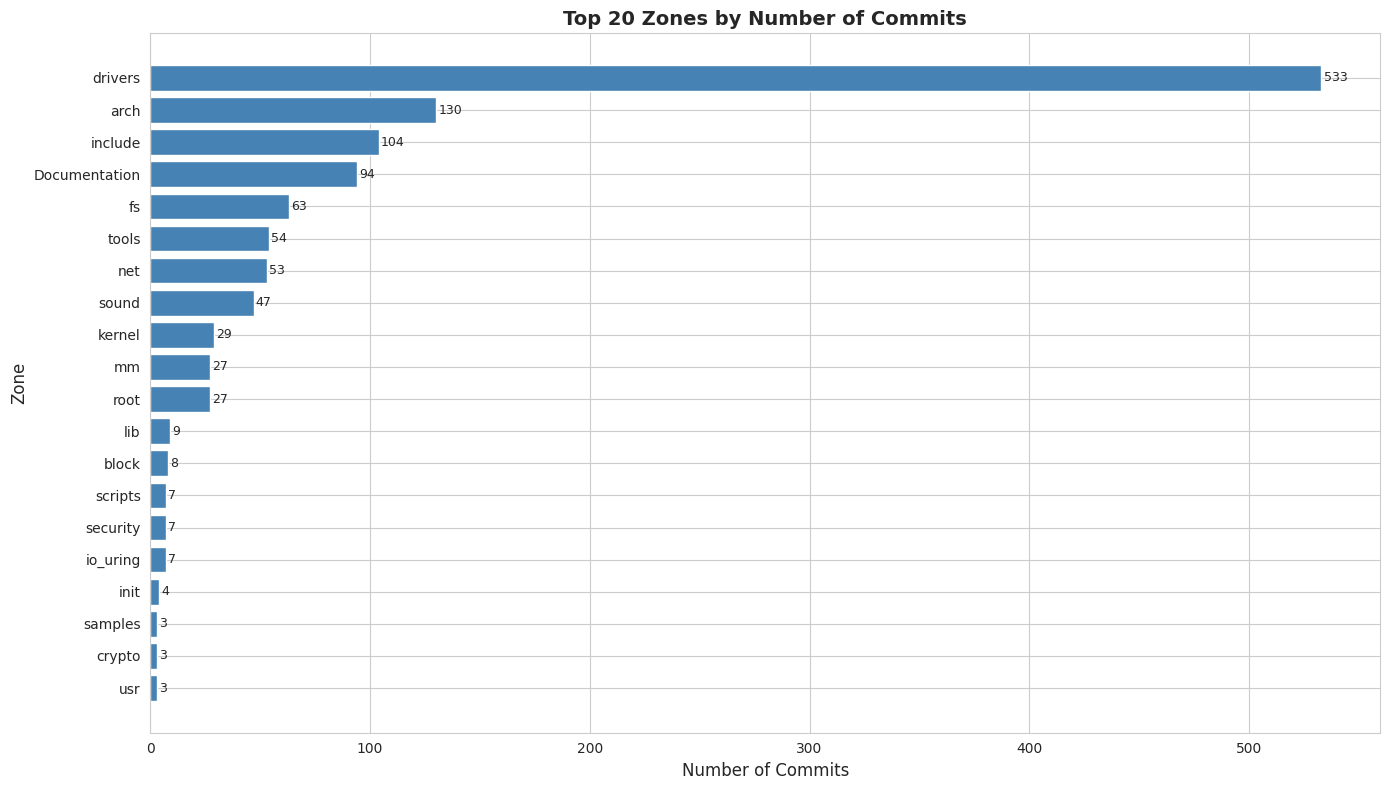

In [8]:
# Plot the top 20 zones by commit count
top_n = 20
top_zones = zone_df.head(top_n)

plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(top_zones)), top_zones['commit_count'], color='steelblue')
plt.yticks(range(len(top_zones)), top_zones['zone'])
plt.xlabel('Number of Commits', fontsize=12)
plt.ylabel('Zone', fontsize=12)
plt.title(f'Top {top_n} Zones by Number of Commits', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest count at the top

# Add value labels on the bars
for i, (idx, row) in enumerate(top_zones.iterrows()):
    plt.text(row['commit_count'] + 1, i, str(row['commit_count']), 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

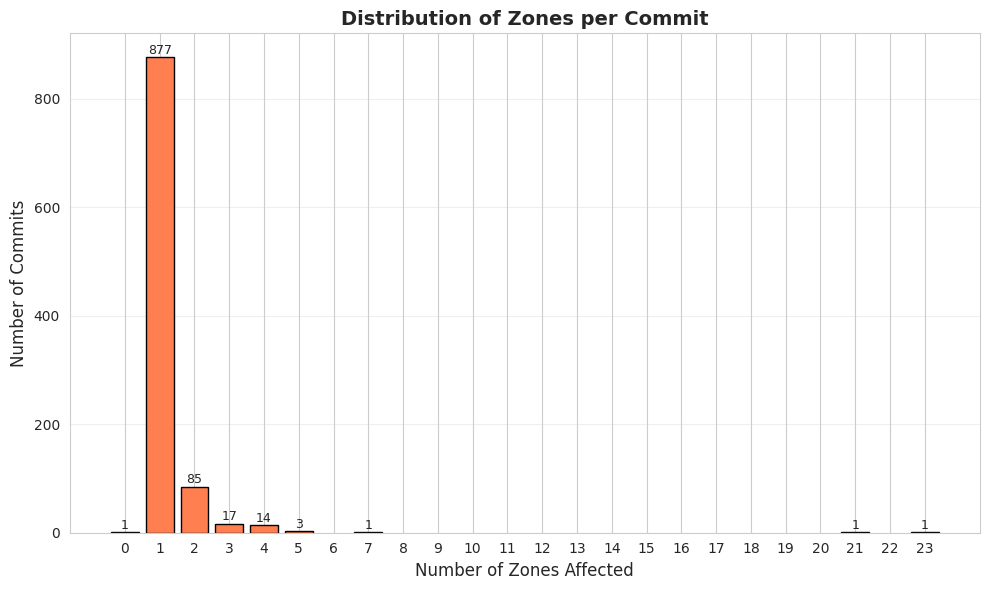

In [9]:
# Additional visualization: Distribution of number of zones per commit
plt.figure(figsize=(10, 6))
num_zones_counts = df['num_zones'].value_counts().sort_index()
plt.bar(num_zones_counts.index, num_zones_counts.values, color='coral', edgecolor='black')
plt.xlabel('Number of Zones Affected', fontsize=12)
plt.ylabel('Number of Commits', fontsize=12)
plt.title('Distribution of Zones per Commit', fontsize=14, fontweight='bold')
plt.xticks(range(int(num_zones_counts.index.min()), int(num_zones_counts.index.max()) + 1))

# Add value labels on the bars
for x, y in zip(num_zones_counts.index, num_zones_counts.values):
    plt.text(x, y + 0.5, str(y), ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Save Enhanced Data

Save the commits with the new zone information to a new file (optional).

In [11]:
# Optionally save the enhanced data
output_path = '../data/1000-linux-commits-with-zones.jsonl'

with open(output_path, 'w', encoding='utf-8') as f:
    for commit in commits:
        f.write(json.dumps(commit) + '\n')

print(f"Enhanced data saved to: {output_path}")

Enhanced data saved to: ../data/1000-linux-commits-with-zones.jsonl
